In [21]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf

import matplotlib.pyplot as plt

### matplotlib 한글 폰트 설정 #############################
from matplotlib import font_manager, rc
## for window #####
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
## for mac #####
#rc('font', family='AppleGothic') #for mac
## linux는 맨 아래 code 참고 #####

from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import time

print(tf.__version__)

2.13.0


In [23]:
!pip install KoNLPy

In [24]:
from konlpy.tag import Twitter
import pandas as pd
import enum
import os
import re
from sklearn.model_selection import train_test_split
import numpy as np

In [32]:
def loadData():
    dataDF = pd.read_csv('./data_in/ChatBotData.csv', header=0)
    
    question, answer = list(dataDF['Q']), list(dataDF['A'])
#     dataset = dataDF['Q'] + '\t' + dataDF['A']
#     dataset = list(dataset)
    # skleran에서 지원하는 함수를 통해서 학습 셋과 
    # 테스트 셋을 나눈다.
#     xTrain, xTest, yTrain, yTest = train_test_split(question, answer, test_size=0.33, random_state=42)
    # 그 값을 리턴한다.
#     return xTrain, yTrain, xTest, yTest
    return question, answer

def preproLikeMorphlized(data):
    # 형태소 분석 모듈 객체를
    # 생성합니다.

    morphAnalyzer = Twitter()
    # 형태소 토크나이즈 결과 문장을 받을
    #  리스트를 생성합니다.
    result_data = list()
    # 데이터에 있는 매 문장에 대해 토크나이즈를
    # 할 수 있도록 반복문을 선언합니다.
    for seq in data:
        # Twitter.morphs 함수를 통해 토크나이즈 된
        # 리스트 객체를 받고 다시 공백문자를 기준으로
        # 하여 문자열로 재구성 해줍니다.
        morphlizedSeq = " ".join(morphAnalyzer.morphs(seq.replace(' ', '')))
        result_data.append(morphlizedSeq)

    return result_data

def dataTokenizer(data):
    # 토크나이징 해서 담을 배열 생성
    words = []
    for sentence in data:
        # FILTERS = "([~.,!?\"':;)(])"
        # 위 필터와 같은 값들을 정규화 표현식을 
        # 통해서 모두 "" 으로 변환 해주는 부분이다.
        sentence = re.sub(change_filter, "", sentence)
        for word in sentence.split():
            words.append(word)
    # 토그나이징과 정규표현식을 통해 만들어진 
    # 값들을 넘겨 준다.
    return [word for word in words if word]

def preprocess_sentence(w):
    
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ." 
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    
    w = w.rstrip().strip()
    
    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    
    return w

def create_dataset(data, num_examples):
#     word_pairs = [[preprocess_sentence(w) for w in l]  for l in data[:num_examples]]
    word_pairs = [[preprocess_sentence(l)]  for l in data[:num_examples]]
    return word_pairs

class LanguageIndex():
    def __init__(self, lang):
        self.lang = lang
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()

        self.create_index()
        
    def create_index(self):
        for phrase in self.lang:
#             if self.vocab == '<start>':
#                 pass
            self.vocab.update(phrase.split(' '))
    
        self.vocab = sorted(self.vocab)
    
        self.word2idx['<pad>'] = 0
#         self.word2idx['<start>'] = 1
#         self.word2idx['<end>'] = 2
#         self.word2idx['<unk>'] = 3

        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1

        for word, index in self.word2idx.items():
            self.idx2word[index] = word
            
def max_length(tensor):
    return max(len(t) for t in tensor)

In [33]:
num_examples = 11823

input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_targ = load_dataset('./data_in/ChatBotData.csv', num_examples)

# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

11823


(9458, 9458, 2365, 2365)

In [34]:
max_length_targ

26

In [35]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
N_BATCH = BUFFER_SIZE//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word2idx)
vocab_tar_size = len(targ_lang.word2idx)

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True) #drop_reainder가 True이면, batch size가 적지 않도록 수정

In [36]:
def gru(units):
    return tf.keras.layers.GRU(units, 
                               return_sequences=True, 
                               return_state=True, 
                               recurrent_activation='sigmoid', 
                               recurrent_initializer='glorot_uniform')
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.enc_units)
        
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        print("state: {}".format(state.shape))
        print("output: {}".format(state.shape))
              
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.dec_units)
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        # used for attention
        self.W1 = tf.keras.layers.Dense(self.dec_units)
        self.W2 = tf.keras.layers.Dense(self.dec_units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        # * `score = FC(tanh(FC(EO) + FC(H)))`
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying tanh(FC(EO) + FC(H)) to self.V
        score = self.V(tf.nn.tanh(self.W1(enc_output) + self.W2(hidden_with_time_axis)))
                
        #* `attention weights = softmax(score, axis = 1)`. Softmax by default is applied on the last axis but here we want to apply it on the *1st axis*, since the shape of score is *(batch_size, max_length, 1)*. `Max_length` is the length of our input. Since we are trying to assign a weight to each input, softmax should be applied on that axis.
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        # * `context vector = sum(attention weights * EO, axis = 1)`. Same reason as above for choosing axis as 1.
        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        # * `embedding output` = The input to the decoder X is passed through an embedding layer.
        x = self.embedding(x)
        
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        # * `merged vector = concat(embedding output, context vector)`
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        # passing the concatenated vector to the GRU
        output, state = self.gru(x)
        
        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        
        # output shape == (batch_size * 1, vocab)
        x = self.fc(output)
        
        return x, state, attention_weights
        
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.dec_units))
print(vocab_inp_size, vocab_tar_size, embedding_dim, units, BATCH_SIZE)

encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

13422 9856 256 1024 64


In [37]:
optimizer = tf.keras.optimizers.Adam()

def loss_function(real, pred):
    mask = 1 - np.equal(real, 0)
    loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
    
#     print("real: {}".format(real))
#     print("pred: {}".format(pred))
#     print("mask: {}".format(mask))
#     print("loss: {}".format(tf.reduce_mean(loss_)))
    
    return tf.reduce_mean(loss_)

In [38]:
checkpoint_dir = './data_out/training_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [39]:
EPOCHS = 1

#GPU 설정
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

for epoch in range(EPOCHS):
    start = time.time()
    
    hidden = encoder.initialize_hidden_state()
    total_loss = 0
    
    for (batch, (inp, targ)) in enumerate(dataset):
        loss = 0
        
        with tf.GradientTape() as tape:
            enc_output, enc_hidden = encoder(inp, hidden)
            
            dec_hidden = enc_hidden
            
            dec_input = tf.expand_dims([targ_lang.word2idx['<start>']] * BATCH_SIZE, 1)
            
            # Teacher forcing - feeding the target as the next input
            for t in range(1, targ.shape[1]):
                # passing enc_output to the decoder
                predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
                
                loss += loss_function(targ[:, t], predictions)
                
                # using teacher forcing
                dec_input = tf.expand_dims(targ[:, t], 1)
        
        batch_loss = (loss / int(targ.shape[1]))
        
        total_loss += batch_loss
        
        variables = encoder.variables + decoder.variables
        
        gradients = tape.gradient(loss, variables)
        
        optimizer.apply_gradients(zip(gradients, variables))
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
          checkpoint.save(file_prefix = checkpoint_prefix)
    
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss / N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

state: (64, 1024)
output: (64, 1024)
Epoch 1 Batch 0 Loss 2.0116
state: (64, 1024)
output: (64, 1024)
state: (64, 1024)
output: (64, 1024)
state: (64, 1024)
output: (64, 1024)
state: (64, 1024)
output: (64, 1024)
state: (64, 1024)
output: (64, 1024)
state: (64, 1024)
output: (64, 1024)
state: (64, 1024)
output: (64, 1024)
state: (64, 1024)
output: (64, 1024)
state: (64, 1024)
output: (64, 1024)
state: (64, 1024)
output: (64, 1024)
state: (64, 1024)
output: (64, 1024)
state: (64, 1024)
output: (64, 1024)
state: (64, 1024)
output: (64, 1024)
state: (64, 1024)
output: (64, 1024)
state: (64, 1024)
output: (64, 1024)
state: (64, 1024)
output: (64, 1024)
state: (64, 1024)
output: (64, 1024)
state: (64, 1024)
output: (64, 1024)
state: (64, 1024)
output: (64, 1024)
state: (64, 1024)
output: (64, 1024)
state: (64, 1024)
output: (64, 1024)
state: (64, 1024)
output: (64, 1024)
state: (64, 1024)
output: (64, 1024)
state: (64, 1024)
output: (64, 1024)
state: (64, 1024)
output: (64, 1024)
state: (64

In [40]:
def evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    
    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word2idx[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word2idx['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        
        # storing the attention weigths to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.idx2word[predicted_id] + ' '

        if targ_lang.idx2word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [41]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize': 14}
    
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()
def translate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    result, sentence, attention_plot = evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)
        
    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(result))
    
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [42]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

state: (1, 1024)
output: (1, 1024)
Input: <start> 뭐라도 배워볼까 . <end>
Predicted translation: . . <end> 


C:\Users\johnk\AppData\Local\Temp\ipykernel_20720\4112932276.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
C:\Users\johnk\AppData\Local\Temp\ipykernel_20720\4112932276.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


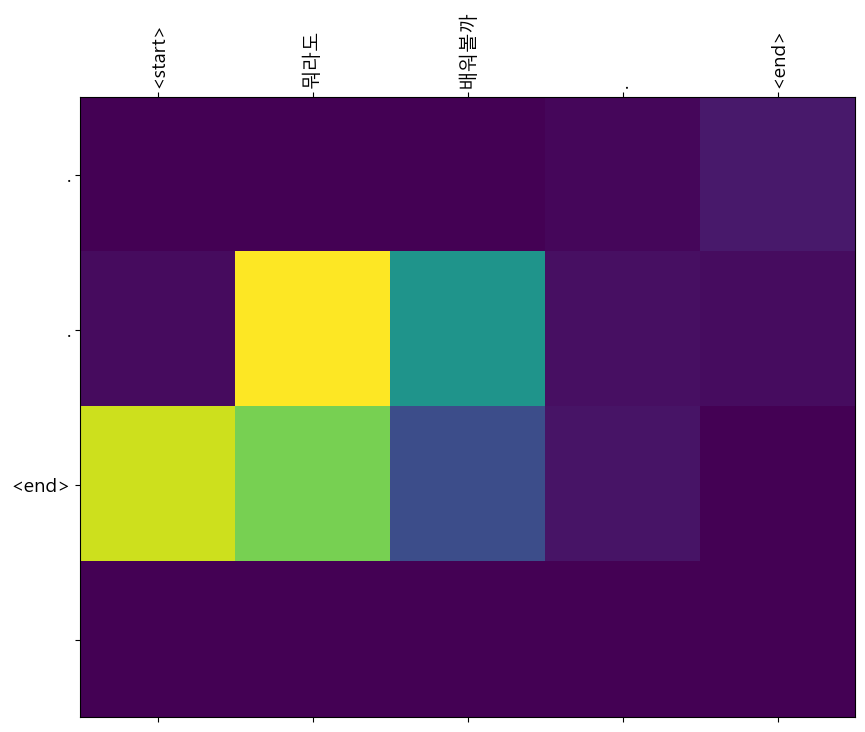

In [43]:
translate('뭐라도 배워볼까.', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)